In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install SoccerNet

In [ ]:
from SoccerNet.Downloader import SoccerNetDownloader
mySoccerNetDownloader = SoccerNetDownloader(LocalDirectory="/content/drive/MyDrive/Colab Notebooks/Artificial Vision/Contest/SoccerNet")
#scarichiamo lo split di train per finetunare il modello sui nostri dati
mySoccerNetDownloader.downloadDataTask(task="tracking-2023", split=["train"])

In [2]:
import os
import zipfile
from tqdm.notebook import tqdm

# Percorsi
zipFile_path = "/content/drive/MyDrive/Colab Notebooks/Artificial Vision/Contest/SoccerNet/tracking-2023/train.zip"
train_data = "/content/train"
local_zip = "/content/train_dataset.zip"

# Funzione per copiare con progress bar
def copy_with_progress(src, dst):
    total_size = os.path.getsize(src)
    with open(src, 'rb') as fsrc, open(dst, 'wb') as fdst:
        with tqdm(total=total_size, unit='B', unit_scale=True, desc="Copia da Drive") as pbar:
            while True:
                # Leggiamo a blocchi di 1MB per efficienza
                chunk = fsrc.read(1024 * 1024)
                if not chunk:
                    break
                fdst.write(chunk)
                pbar.update(len(chunk))

# Logica principale
if not os.path.exists(train_data):
    print("Inizio procedura di estrazione...")

    # 1. Copia da Drive
    if not os.path.exists(local_zip): # Copia solo se non c'è già lo zip locale
        copy_with_progress(zipFile_path, local_zip)
    else:
        print("Zip locale già presente, salto la copia.")

    # 2. Unzip (con barra)
    print("Analisi contenuto zip...")
    with zipfile.ZipFile(local_zip, 'r') as zf:
        # Recuperiamo la lista dei file per impostare la barra
        file_list = zf.infolist()

        # Estraiamo un file alla volta aggiornando la barra
        for member in tqdm(file_list, desc="Estrazione file", unit="file"):
            zf.extract(member, train_data)

    # 3. Pulizia
    os.remove(local_zip)
    print(f"Finito! Dataset pronto in: {train_data}")

else:
    print("Dati già presenti nella cartella di destinazione!")

Inizio procedura di estrazione...


Copia da Drive:   0%|          | 0.00/9.58G [00:00<?, ?B/s]

Analisi contenuto zip...


Estrazione file:   0%|          | 0/43207 [00:00<?, ?file/s]

Finito! Dataset pronto in: /content/train


In [3]:
# Sposta tutto il contenuto di train/train in train/
!mv /content/train/train/* /content/train/

# Rimuovi la cartella vuota interna
!rmdir /content/train/train

# Verifica
!ls /content/train | head

SNMOT-060
SNMOT-061
SNMOT-062
SNMOT-063
SNMOT-064
SNMOT-065
SNMOT-066
SNMOT-067
SNMOT-068
SNMOT-069


Rimozione delle righe che contengono l'id 'ball' nei file gt.txt

In [4]:
import re

# Configurazione Percorso
TRAIN_FOLDER_PATH = "/content/train"

def get_ball_ids_from_gameinfo(gameinfo_file):
    ball_ids = set()
    try:
        with open(gameinfo_file, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line or "=" not in line:
                    continue

                left, right = line.split("=", 1)
                left = left.strip()
                right = right.strip()

                label = right.split(";", 1)[0].strip().lower()
                if label != "ball":
                    continue

                m = re.match(r"trackletID_(\d+)$", left, flags=re.IGNORECASE)
                if m:
                    ball_ids.add(m.group(1))
    except FileNotFoundError:
        return set()

    return ball_ids

def filter_gt_in_place(video_folder_path, dir_name):
    gameinfo_path = os.path.join(video_folder_path, "gameinfo.ini")
    gt_file_path = os.path.join(video_folder_path, "gt", "gt.txt")

    if not os.path.exists(gameinfo_path) or not os.path.exists(gt_file_path):
        return False

    ball_ids = get_ball_ids_from_gameinfo(gameinfo_path)

    if not ball_ids:
        return False

    try:
        with open(gt_file_path, "r", encoding="utf-8") as f:
            lines = f.readlines()

        filtered_lines = []
        removed_count = 0

        for line in lines:
            parts = line.strip().split(",")
            if len(parts) < 2:
                filtered_lines.append(line)
                continue

            obj_id = parts[1].strip()

            if obj_id in ball_ids:
                removed_count += 1
                continue

            filtered_lines.append(line)

        if removed_count > 0:
            with open(gt_file_path, "w", encoding="utf-8") as f:
                f.writelines(filtered_lines)

            tqdm.write(f"[OK] {dir_name} | ball_ids={sorted(list(ball_ids))} | righe rimosse={removed_count}")

            return True

        return False

    except Exception as e:
        tqdm.write(f"[ERR] Errore processando {gt_file_path}: {e}")
        return False

def process_train_dataset():
    print(f"Inizio rimozione 'ball' dai GT in: {TRAIN_FOLDER_PATH}")

    if not os.path.exists(TRAIN_FOLDER_PATH):
        print(f"Errore: La cartella {TRAIN_FOLDER_PATH} non esiste.")
        return

    dirs = [d for d in os.listdir(TRAIN_FOLDER_PATH) if os.path.isdir(os.path.join(TRAIN_FOLDER_PATH, d))]
    dirs.sort()

    modified_files = 0

    for dir_name in tqdm(dirs, desc="Pulizia Dataset", unit="video"):
        video_folder_path = os.path.join(TRAIN_FOLDER_PATH, dir_name)

        if filter_gt_in_place(video_folder_path, dir_name):
            modified_files += 1

    print(f"\n[COMPLETATO]")
    print(f"Totale video analizzati: {len(dirs)}")
    print(f"File gt.txt modificati: {modified_files}")

process_train_dataset()

Inizio rimozione 'ball' dai GT in: /content/train


Pulizia Dataset:   0%|          | 0/57 [00:00<?, ?video/s]

[OK] SNMOT-060 | ball_ids=['18'] | righe rimosse=734
[OK] SNMOT-061 | ball_ids=['1', '27'] | righe rimosse=740
[OK] SNMOT-062 | ball_ids=['19'] | righe rimosse=750
[OK] SNMOT-063 | ball_ids=['19'] | righe rimosse=750
[OK] SNMOT-064 | ball_ids=['23'] | righe rimosse=590
[OK] SNMOT-065 | ball_ids=['24', '26'] | righe rimosse=675
[OK] SNMOT-066 | ball_ids=['24'] | righe rimosse=724
[OK] SNMOT-067 | ball_ids=['22'] | righe rimosse=707
[OK] SNMOT-068 | ball_ids=['8'] | righe rimosse=718
[OK] SNMOT-069 | ball_ids=['18', '24'] | righe rimosse=768
[OK] SNMOT-070 | ball_ids=['12'] | righe rimosse=737
[OK] SNMOT-071 | ball_ids=['20'] | righe rimosse=701
[OK] SNMOT-072 | ball_ids=['1'] | righe rimosse=650
[OK] SNMOT-073 | ball_ids=['19'] | righe rimosse=711
[OK] SNMOT-074 | ball_ids=['23'] | righe rimosse=750
[OK] SNMOT-075 | ball_ids=['22', '24'] | righe rimosse=552
[OK] SNMOT-076 | ball_ids=['25'] | righe rimosse=609
[OK] SNMOT-077 | ball_ids=['20'] | righe rimosse=733
[OK] SNMOT-097 | ball_ids

Conversione file MOT in formato YOLO

In [5]:
import shutil
import cv2
import random

# --- CONFIGURAZIONE ---
SOURCE_DIR = '/content/train'          # Dove sono le cartelle SNMOT-xxx
OUTPUT_DIR = '/content/yolo_dataset'   # Dove creeremo il dataset per YOLO
VAL_SPLIT = 0.2                        # 20% dei video usati per validazione

# Mappa classi: Siccome abbiamo tolto la palla, assumiamo che tutto il resto sia "persona" (class 0)
CLASS_ID = 0

def convert_box(size, box):
    # box = (left, top, w, h) -> pixel
    # size = (img_width, img_height)
    # return (x_center, y_center, w, h) -> normalizzato 0-1
    dw = 1. / size[0]
    dh = 1. / size[1]

    x = box[0] + box[2] / 2.0
    y = box[1] + box[3] / 2.0
    w = box[2]
    h = box[3]

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

def create_yolo_dataset():
    # 1. Creiamo la struttura cartelle
    for split in ['train', 'val']:
        os.makedirs(os.path.join(OUTPUT_DIR, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(OUTPUT_DIR, 'labels', split), exist_ok=True)

    # 2. Otteniamo lista video
    video_folders = sorted([d for d in os.listdir(SOURCE_DIR) if os.path.isdir(os.path.join(SOURCE_DIR, d))])

    # Mischiamo e splittiamo i VIDEO (non i frame, per evitare data leakage)
    random.seed(42)
    random.shuffle(video_folders)
    split_idx = int(len(video_folders) * (1 - VAL_SPLIT))
    train_videos = video_folders[:split_idx]
    val_videos = video_folders[split_idx:]

    print(f"Video totali: {len(video_folders)}")
    print(f"Train: {len(train_videos)} video | Val: {len(val_videos)} video")

    # Funzione per processare una lista di video
    def process_videos(video_list, split_name):
        for vid_name in tqdm(video_list, desc=f"Processando {split_name}", unit="vid"):
            vid_path = os.path.join(SOURCE_DIR, vid_name)
            img_dir = os.path.join(vid_path, 'img1')
            gt_path = os.path.join(vid_path, 'gt', 'gt.txt')

            # Se manca gt o immagini, saltiamo
            if not os.path.exists(gt_path) or not os.path.exists(img_dir):
                continue

            # --- A. Leggiamo dimensioni immagine (basta la prima) ---
            first_img_path = os.path.join(img_dir, "000001.jpg")
            if not os.path.exists(first_img_path): continue # check sicurezza

            img = cv2.imread(first_img_path)
            if img is None: continue
            height, width = img.shape[:2]

            # --- B. Carichiamo GT e raggruppiamo per frame ---
            # gt.txt format: frame, id, left, top, w, h, ...
            frame_annotations = {}

            with open(gt_path, 'r') as f:
                for line in f:
                    parts = line.strip().split(',')
                    if len(parts) < 6: continue

                    frame_id = int(parts[0])
                    # MOT: left, top, w, h
                    box_mot = (float(parts[2]), float(parts[3]), float(parts[4]), float(parts[5]))

                    # Convertiamo SUBITO in YOLO format
                    box_yolo = convert_box((width, height), box_mot)

                    if frame_id not in frame_annotations:
                        frame_annotations[frame_id] = []
                    frame_annotations[frame_id].append(box_yolo)

            # --- C. Copiamo immagini e creiamo txt ---
            # Iteriamo sui file nella cartella img1
            images = sorted([i for i in os.listdir(img_dir) if i.endswith('.jpg')])

            for img_file in images:
                # Estraiamo numero frame dal nome file (000001.jpg -> 1)
                frame_num = int(os.path.splitext(img_file)[0])

                # Nuovo nome univoco: SNMOT-060_000001
                new_filename = f"{vid_name}_{os.path.splitext(img_file)[0]}"

                # Percorsi destinazione
                dst_img = os.path.join(OUTPUT_DIR, 'images', split_name, new_filename + ".jpg")
                dst_txt = os.path.join(OUTPUT_DIR, 'labels', split_name, new_filename + ".txt")

                # 1. Copia immagine (shutil.copy è più sicuro di move qui)
                shutil.copy(os.path.join(img_dir, img_file), dst_img)

                # 2. Scrivi annotazioni (se esistono per questo frame)
                if frame_num in frame_annotations:
                    with open(dst_txt, 'w') as f_out:
                        for box in frame_annotations[frame_num]:
                            # YOLO format: class x y w h
                            f_out.write(f"{CLASS_ID} {box[0]:.6f} {box[1]:.6f} {box[2]:.6f} {box[3]:.6f}\n")
                else:
                    # Se non ci sono oggetti in questo frame (raro in tracking, ma possibile),
                    # creiamo un file vuoto (YOLO lo accetta come negative sample)
                    open(dst_txt, 'w').close()

    # Eseguiamo
    process_videos(train_videos, 'train')
    process_videos(val_videos, 'val')

    # 3. Creiamo il file data.yaml necessario per il training
    yaml_content = f"""
path: {OUTPUT_DIR}
train: images/train
val: images/val
names:
  0: player
"""
    with open(os.path.join(OUTPUT_DIR, 'data.yaml'), 'w') as f:
        f.write(yaml_content)

    print(f"\n[FATTO] Dataset YOLO creato in: {OUTPUT_DIR}")
    print("File data.yaml creato. Pronto per il training!")

create_yolo_dataset()

Video totali: 57
Train: 45 video | Val: 12 video


Processando train:   0%|          | 0/45 [00:00<?, ?vid/s]

Processando val:   0%|          | 0/12 [00:00<?, ?vid/s]


[FATTO] Dataset YOLO creato in: /content/yolo_dataset
File data.yaml creato. Pronto per il training!


Controllo che tutte le gt siano state convertite correttamente

In [6]:
import glob
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURAZIONE ---
ORIGINAL_GT_PATH = '/content/train'
YOLO_DATASET_PATH = '/content/yolo_dataset'
IMG_RES_W = 1920
IMG_RES_H = 1080

# Dove salvare il video di verifica (Su Drive per scaricarlo)
VIDEO_OUTPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/Artificial Vision/Contest/ValidationVideos'
os.makedirs(VIDEO_OUTPUT_DIR, exist_ok=True)

# Quale video ricostruire per il test?
TEST_VIDEO_ID = 'SNMOT-060'

def test_1_mathematical_precision():
    print("🔬 TEST 1: Verifica Precisione Matematica (Originale vs YOLO)...")

    # 1. Prendiamo un video e un frame a caso (es. SNMOT-060, Frame 1)
    video_folders = sorted(glob.glob(os.path.join(ORIGINAL_GT_PATH, 'SNMOT*')))
    if not video_folders:
        print("❌ Errore: Cartelle originali non trovate.")
        return

    test_video = video_folders[0] # Es. SNMOT-060
    video_name = os.path.basename(test_video)
    gt_path = os.path.join(test_video, 'gt', 'gt.txt')

    # 2. Leggiamo la prima riga valida del GT originale
    target_gt = None
    with open(gt_path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            frame = int(parts[0])
            if frame == 1:
                target_gt = {
                    'left': float(parts[2]),
                    'top': float(parts[3]),
                    'w': float(parts[4]),
                    'h': float(parts[5])
                }
                break

    if target_gt is None:
        print("⚠️ Nessun oggetto trovato nel frame 1 per il test.")
        return

    # 3. Calcoliamo i valori ATTESI (Expected)
    img_path = os.path.join(test_video, 'img1', '000001.jpg')
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        h_img, w_img = img.shape[:2]
    else:
        h_img, w_img = IMG_RES_H, IMG_RES_W

    expected_x = (target_gt['left'] + target_gt['w'] / 2) / w_img
    expected_y = (target_gt['top'] + target_gt['h'] / 2) / h_img
    expected_w = target_gt['w'] / w_img
    expected_h = target_gt['h'] / h_img

    print(f"   Dati Originali (Pixel): Left={target_gt['left']}, Top={target_gt['top']}, W={target_gt['w']}, H={target_gt['h']}")
    print(f"   Valori Attesi (YOLO):   X={expected_x:.6f}, Y={expected_y:.6f}, W={expected_w:.6f}, H={expected_h:.6f}")

    # 4. Cerchiamo il valore nel file YOLO generato
    yolo_file = None
    possible_paths = [
        os.path.join(YOLO_DATASET_PATH, 'labels', 'train', f"{video_name}_000001.txt"),
        os.path.join(YOLO_DATASET_PATH, 'labels', 'val', f"{video_name}_000001.txt")
    ]

    found_match = False

    for path in possible_paths:
        if os.path.exists(path):
            yolo_file = path
            with open(path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    parts = list(map(float, line.strip().split()))
                    # Confronto con tolleranza (epsilon)
                    if np.allclose([parts[1], parts[2], parts[3], parts[4]],
                                   [expected_x, expected_y, expected_w, expected_h],
                                   atol=0.001):
                        found_match = True
                        print(f"   ✅ TROVATO MATCH ESATTO nel file: {path}")
                        print(f"   Valori Trovati:         X={parts[1]:.6f}, Y={parts[2]:.6f}, W={parts[3]:.6f}, H={parts[4]:.6f}")
                        break
            if found_match: break

    if not found_match:
        print("   ❌ ERRORE: Non ho trovato i valori attesi nel file YOLO.")
    else:
        print("   ✅ Test Matematico SUPERATO.")


def test_2_dataset_integrity():
    print("\n🛡️ TEST 2: Controllo Integrità Dataset (Range 0-1)...")
    label_files = glob.glob(os.path.join(YOLO_DATASET_PATH, 'labels', '*', '*.txt'))
    errors = 0

    for lf in tqdm(label_files, desc="Scansione File"):
        with open(lf, 'r') as f:
            for i, line in enumerate(f):
                parts = list(map(float, line.strip().split()))
                if len(parts) != 5:
                    errors += 1
                if not (0 <= parts[1] <= 1 and 0 <= parts[2] <= 1 and 0 <= parts[3] <= 1.2 and 0 <= parts[4] <= 1.2):
                    print(f"   ❌ Valore fuori range in {os.path.basename(lf)}: {line.strip()}")
                    errors += 1

    if errors == 0:
        print("   ✅ Nessun errore di formato o valori fuori scala rilevati.")
    else:
        print(f"   ❌ Trovati {errors} errori potenziali.")

def test_3_visual_confirmation():
    print("\n👁️ TEST 3: Conferma Visiva (Disegno Box)...")
    img_files = glob.glob(os.path.join(YOLO_DATASET_PATH, 'images', 'train', '*.jpg'))
    if not img_files: return

    sample_img = np.random.choice(img_files)
    label_file = sample_img.replace('images', 'labels').replace('.jpg', '.txt')

    img = cv2.imread(sample_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    if os.path.exists(label_file):
        with open(label_file, 'r') as f:
            for line in f:
                parts = list(map(float, line.strip().split()))
                x_c, y_c, bw, bh = parts[1], parts[2], parts[3], parts[4]
                x1 = int((x_c - bw/2) * w)
                y1 = int((y_c - bh/2) * h)
                x2 = int((x_c + bw/2) * w)
                y2 = int((y_c + bh/2) * h)
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.title(f"Check Visivo: {os.path.basename(sample_img)}")
    plt.axis('off')
    plt.show()

def test_4_video_reconstruction():
    print(f"\n🎬 TEST 4: Ricostruzione Video dai dati YOLO ({TEST_VIDEO_ID})...")

    # 1. Cerchiamo tutte le immagini convertite appartenenti a questo video
    # Nota: potrebbero essere state divise tra train e val, quindi cerchiamo ovunque
    pattern = f"{TEST_VIDEO_ID}_*.jpg"
    found_images = []

    for split in ['train', 'val']:
        search_path = os.path.join(YOLO_DATASET_PATH, 'images', split, pattern)
        found_images.extend(glob.glob(search_path))

    if not found_images:
        print(f"❌ Nessuna immagine trovata per il video {TEST_VIDEO_ID} nel dataset YOLO.")
        return

    # 2. Ordiniamo le immagini (fondamentale per il video)
    # Estraiamo il numero frame dal nome: SNMOT-060_000001.jpg -> 1
    def get_frame_num(filename):
        base = os.path.basename(filename)
        # Rimuove estensione e prende la parte dopo l'ultimo underscore
        num_str = base.replace('.jpg', '').split('_')[-1]
        return int(num_str)

    found_images.sort(key=get_frame_num)

    print(f"   Trovati {len(found_images)} frame. Generazione video in corso...")

    # 3. Setup Video Writer
    first_img = cv2.imread(found_images[0])
    h, w = first_img.shape[:2]
    out_path = os.path.join(VIDEO_OUTPUT_DIR, f"{TEST_VIDEO_ID}_from_YOLO_labels.mp4")

    # Codec
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(out_path, fourcc, 25.0, (w, h))

    # 4. Loop Frame
    for img_path in tqdm(found_images, desc="Rendering Video", unit="frame"):
        img = cv2.imread(img_path)

        # Trova label corrispondente
        # .../images/train/X.jpg -> .../labels/train/X.txt
        lbl_path = img_path.replace('images', 'labels').replace('.jpg', '.txt')

        if os.path.exists(lbl_path):
            with open(lbl_path, 'r') as f:
                for line in f:
                    parts = list(map(float, line.strip().split()))
                    # class x_c y_c w h
                    cls, x_c, y_c, bw, bh = parts

                    # Denormalizza
                    x1 = int((x_c - bw/2) * w)
                    y1 = int((y_c - bh/2) * h)
                    x2 = int((x_c + bw/2) * w)
                    y2 = int((y_c + bh/2) * h)

                    # Disegna BOX (Verde)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Aggiungi frame number
        cv2.putText(img, f"YOLO Data - Frame {get_frame_num(img_path)}", (30, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

        out.write(img)

    out.release()
    print(f"   ✅ Video salvato in: {out_path}")


# --- ESECUZIONE ---
test_1_mathematical_precision()
test_2_dataset_integrity()

🔬 TEST 1: Verifica Precisione Matematica (Originale vs YOLO)...
   Dati Originali (Pixel): Left=914.0, Top=855.0, W=55.0, H=172.0
   Valori Attesi (YOLO):   X=0.490365, Y=0.871296, W=0.028646, H=0.159259
   ✅ TROVATO MATCH ESATTO nel file: /content/yolo_dataset/labels/train/SNMOT-060_000001.txt
   Valori Trovati:         X=0.490365, Y=0.871296, W=0.028646, H=0.159259
   ✅ Test Matematico SUPERATO.

🛡️ TEST 2: Controllo Integrità Dataset (Range 0-1)...


Scansione File:   0%|          | 0/42750 [00:00<?, ?it/s]

   ✅ Nessun errore di formato o valori fuori scala rilevati.



👁️ TEST 3: Conferma Visiva (Disegno Box)...


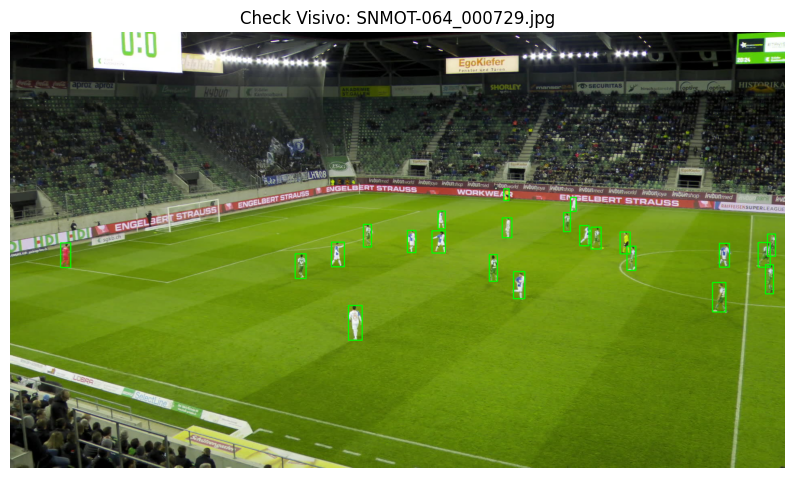

In [7]:
test_3_visual_confirmation()

Check video per assicurarci che le gt sono corrette

In [20]:
test_4_video_reconstruction()


🎬 TEST 4: Ricostruzione Video dai dati YOLO (SNMOT-060)...
   Trovati 750 frame. Generazione video in corso...


Rendering Video:   0%|          | 0/750 [00:00<?, ?frame/s]

   ✅ Video salvato in: /content/drive/MyDrive/Colab Notebooks/Artificial Vision/Contest/ValidationVideos/SNMOT-060_from_YOLO_labels.mp4
   Controlla Drive per scaricarlo e visualizzarlo.


Campiono ogni 5 frame per velocizzare l'addestramento

In [7]:
import yaml

# --- 1. CONFIGURAZIONE ---
dataset_path = '/content/yolo_dataset'
original_yaml = f'{dataset_path}/data.yaml'
new_yaml = f'{dataset_path}/data_subsampled.yaml'

# Ogni quanti frame prenderne uno?
# 5 è conservativo (80% di riduzione), 10 è aggressivo (90% riduzione).
# Dato che vogliamo fare 1280px, consiglio 5.
STEP = 5

# --- 2. CREAZIONE LISTA SUBSAMPLED ---
# YOLO accetta un file .txt con la lista dei percorsi delle immagini invece di una cartella
train_images = sorted(glob.glob(f'{dataset_path}/images/train/*.jpg'))
val_images = sorted(glob.glob(f'{dataset_path}/images/val/*.jpg'))

# Prendiamo 1 frame ogni STEP
train_subset = train_images[::STEP]
# Il validation set lo teniamo tutto o lo riduciamo? Meglio ridurlo per velocizzare la validazione a fine epoca
val_subset = val_images[::STEP]

print(f"Dataset Originale: {len(train_images)} img")
print(f"Dataset Ottimizzato (1 ogni {STEP}): {len(train_subset)} img")

# Salviamo le liste in file txt
train_txt_path = f'{dataset_path}/train_subset.txt'
val_txt_path = f'{dataset_path}/val_subset.txt'

with open(train_txt_path, 'w') as f:
    f.write('\n'.join(train_subset))

with open(val_txt_path, 'w') as f:
    f.write('\n'.join(val_subset))

# --- 3. CREAZIONE NUOVO YAML ---
# Leggiamo lo yaml originale per copiare i nomi delle classi
with open(original_yaml, 'r') as f:
    data = yaml.safe_load(f)

# Modifichiamo i percorsi puntando ai file txt appena creati
data['train'] = train_txt_path
data['val'] = val_txt_path

# Salviamo il nuovo yaml
with open(new_yaml, 'w') as f:
    yaml.dump(data, f)

print(f"\n✅ Creato nuovo file configurazione: {new_yaml}")
print("Usa questo file nel comando model.train()!")

Dataset Originale: 33750 img
Dataset Ottimizzato (1 ogni 5): 6750 img

✅ Creato nuovo file configurazione: /content/yolo_dataset/data_subsampled.yaml
Usa questo file nel comando model.train()!


Training yolo11m imgsz=1280

In [8]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.6 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import torch

torch.cuda.empty_cache()

DATASET_YAML = '/content/yolo_dataset/data_subsampled.yaml'
DRIVE_PROJECT_PATH = '/content/drive/MyDrive/Colab Notebooks/Artificial Vision/Contest/Runs'
EXPERIMENT_NAME = 'yolo11m_HD_Subsampled'

model = YOLO('yolo11m.pt')

results = model.train(
    data=DATASET_YAML,
    imgsz=1280,

    # --- OTTIMIZZAZIONI ---
    batch=16,
    epochs=20,
    freeze=11,

    # --- Standard ---
    device=0,
    workers=8,
    project=DRIVE_PROJECT_PATH,
    name=EXPERIMENT_NAME,
    exist_ok=True,
    patience=5,
    save=True,
    plots=True,
    amp=True,
    verbose=True
)

🚀 Avvio Training TURBO (Batch 16 + Subsample 1/5)...
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset/data_subsampled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=11, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11m_HD_Subsampled, nbs=64, nms=False, opset=None, optimize=False, optimi


image 1/1 /content/yolo_dataset/images/val/SNMOT-066_000009.jpg: 736x1280 23 players, 5443.7ms
Speed: 47.1ms preprocess, 5443.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


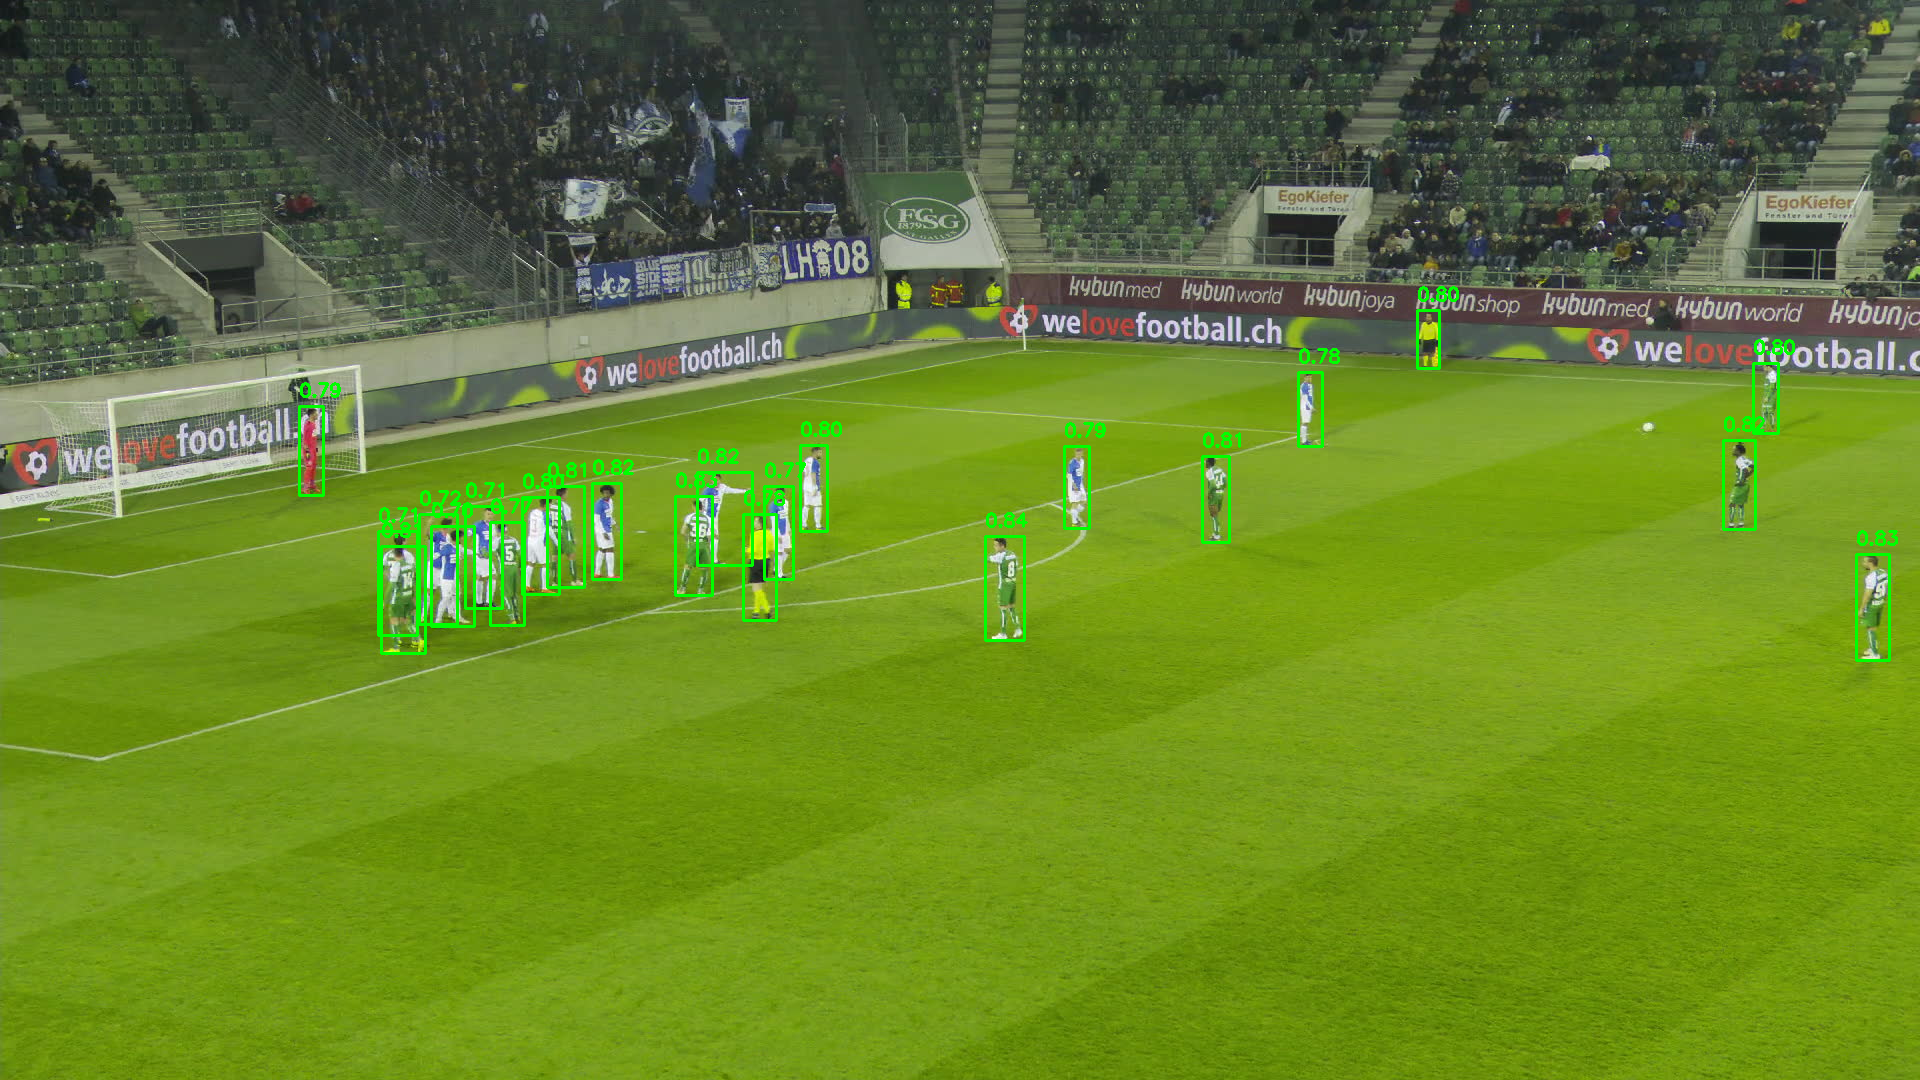

In [15]:
import cv2
from ultralytics import YOLO
from PIL import Image
from IPython.display import display

# 1. Carica il modello
model_path = '/content/drive/MyDrive/Colab Notebooks/Artificial Vision/Contest/Runs/yolo11m_HD_Subsampled/weights/train_yolo11m_SoccerNet.pt'
model = YOLO(model_path)

# 2. Percorso dell'immagine da testare
source_path = '/content/yolo_dataset/images/val/SNMOT-066_000009.jpg'

# 3. Esegui la predizione
# save=True la salva su disco, ma noi vogliamo anche vederla qui
results = model.predict(source=source_path, imgsz=1280, conf=0.25)

for result in results:
    # 1. Prendiamo l'immagine originale come array numpy
    img = result.orig_img.copy()

    # 2. Iteriamo su ogni box trovato
    for box in result.boxes:
        # Coordinate del rettangolo (x1, y1, x2, y2)
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)

        # Confidence (es. 0.85)
        conf = float(box.conf[0])

        # --- DISEGNO PERSONALIZZATO ---

        # A. Disegna il rettangolo (Colore verde: (0, 255, 0), Spessore: 2)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # B. Prepara il testo (Solo il numero, es: "0.85")
        label = f"{conf:.2f}"

        # C. Disegna il testo sopra il box
        # (Coordinate, Font, Scala, Colore testo, Spessore)
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # 3. Converti e mostra
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(img_rgb))